In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [199]:
import os
import sys

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-2])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/datasets".format(ROOT_DIR)
print(DATASET_DIR)

from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler, FunctionTransformer, scale

import torch
import torch.nn as nn
import torch.nn.functional as F # contains functional interface of typical operations used for building nn's
import torch.optim as optim     # contains optimizers e.g. Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, Dataset
from torchmetrics import ConfusionMatrix, Accuracy
from tqdm import tqdm
from torch.nn import functional as F

from lib import utilities

import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

from lime import lime_text
import shap
print("SHAP Version : {}".format(shap.__version__))

torch.set_printoptions(linewidth=120)

/home/djoy2409-wsl/projects/software_development/tox_21_qsar/datasets
SHAP Version : 0.42.1


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In this notebook, we will be predicting AHR activity using data from the Tox21 dataset. We will do so using **LSTMs** along with various **SMILES tokenization algorithms**. A good introduction to LSTMs can be founfd in the  reference below:
> - [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
> - [Long Short-Term Memory: From Zero to Hero with PyTorch](https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/)

In [3]:
# def augment_data(compounds_df, smiles_column, target_column, n_randomizations=1):  
#     temp_dfs = []
#     for index, row in compounds_df.iterrows():
#         original_smiles = row[smiles_column]
#         smiles=[original_smiles]
#         for i in range(n_randomizations):          
#             smiles.append(utilities.randomize_smiles(original_smiles))
# #         print("SMILES = {}".format(smiles))
#         df = pd.DataFrame(list(set(smiles)), columns=[smiles_column])
#         df[target_column] = row[target_column]
# #         print(df)
#         temp_dfs.append(df)
#     final_df = pd.concat(temp_dfs, axis=0)
#     final_df = final_df.reset_index(drop=True)
#     return final_df

\
We will MolVecGen the vectorization of SMILES, which can be installed using pip

In [4]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-3lm4yiiu
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-3lm4yiiu
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset preparation

In [6]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.Chem import PandasTools, MolFromSmiles, AllChem, MolFromSmiles, Draw, MolToInchiKey, MolToSmiles
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

In [7]:
molecule_column = 'Molecule'
smiles_column   = "SMILES"
inchikey_column = "Ambit_InchiKey"
target          = "activity"
canonicalize_first = True

In [8]:
compounds_df = pd.read_csv("{}/compounds/nr-ahr.tab".format(DATASET_DIR), sep="\t")


In [9]:
if canonicalize_first:
    compounds_df["canonical_smiles"] = compounds_df[smiles_column].apply(lambda x : MolToSmiles(MolFromSmiles(x), canonical=True))   
    print(compounds_df[[smiles_column, "canonical_smiles"]].head(5))
    smiles_column = "canonical_smiles"

                                              SMILES  \
0                               CC(C)(C)c1cc(O)ccc1O   
1                               CC(C)(C)c1cc(O)ccc1O   
2   CN(C)c1ccc(cc1)C(c1ccccc1)=C1C=CC(C=C1)=[N+](C)C   
3  COC(=O)[C@H]1[C@@H](O)CC[C@H]2CN3CCc4c5ccccc5[...   
4                   OC(CCN1CCCCC1)(c1ccccc1)c1ccccc1   

                                    canonical_smiles  
0                               CC(C)(C)c1cc(O)ccc1O  
1                               CC(C)(C)c1cc(O)ccc1O  
2   CN(C)c1ccc(C(=C2C=CC(=[N+](C)C)C=C2)c2ccccc2)cc1  
3  COC(=O)[C@@H]1[C@H]2C[C@H]3c4[nH]c5ccccc5c4CCN...  
4                   OC(CCN1CCCCC1)(c1ccccc1)c1ccccc1  


In [10]:
PandasTools.AddMoleculeColumnToFrame(compounds_df,'SMILES',molecule_column, includeFingerprints=True)
compounds_df.Molecule.isna().sum(), compounds_df.shape, compounds_df[["Compound", target]].head(10)

(0,
 (1900, 5),
           Compound  activity
 0  NCGC00013051-01         1
 1  NCGC00013051-05         1
 2  NCGC00013058-01         1
 3  NCGC00013260-01         1
 4  NCGC00013289-01         1
 5  NCGC00013369-03         1
 6  NCGC00013414-03         0
 7  NCGC00013556-01         1
 8  NCGC00013683-01         0
 9  NCGC00014617-01         0)

## Removing duplicates
For several compounds (referrenced by Ambit_inchikeys) there are more than one rows. The target values will be averaged.

In [11]:
if not inchikey_column in compounds_df.columns:
    print("Computing and storing the InChiKeys...")
    compounds_df[inchikey_column] = compounds_df[molecule_column].apply(lambda x: MolToInchiKey(x))

Computing and storing the InChiKeys...


In [12]:
compounds_df = utilities.remove_conflicting_target_values(compounds_df, target, inchikey_column)
compounds = compounds_df[molecule_column].tolist()
compounds_df.shape, compounds_df[["Compound", target]].head(10)

InchIKey CYMPUOGZUXAIMY-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey GZPHSAQLYPIAIN-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey JJYPMNFTHPTTDI-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey MACXEFYJKXWDCK-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey MVWVFYHBGMAFLY-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey VMPITZXILSNTON-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.
InchIKey WYWZRNAHINYAEF-UHFFFAOYSA-N has 2 conflicting activity values. All associated samples will be removed.


((1663, 6),
              Compound  activity
 390   NCGC00164574-01         1
 859   NCGC00255216-01         0
 462   NCGC00178168-02         0
 491   NCGC00181746-01         0
 1144  NCGC00256580-01         0
 278   NCGC00159429-02         0
 1300  NCGC00257536-01         1
 569   NCGC00249415-01         0
 137   NCGC00023902-06         0
 82    NCGC00016497-05         0)

### Tokenization with MolVecGen
We want to identify as many token as possible, and will therefore analyze the whole dataset before performing the splitting.
The [author mentions](https://www.cheminformania.com/building-a-simple-smiles-based-qsar-model-with-lstm-cells-in-pytorch/) that the <em>" SMILES vectorizer analyzes the dataset for what characters it contains and the maximal length. As the augmentation can result in longer SMILES strings as well as the appearance of some additional characters, some extra padding and characters may be needed to avoid too many “?” which are unknown characters"</em>.\
</br>
We want to identify as many token as possible, and will therefore analyze the whole dataset before performing the splitting.

In [13]:
from molvecgen.vectorizers import SmilesVectorizer
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(compounds_df.Molecule.values, )
print(smivec.charset)
print(smivec.dims)

gl=@812+e4]6/[A3P(N\TO#F-s5rdBuao7HI)cCnSi^$?
(291, 45)


In [14]:
compounds_smivec = smivec.transform(compounds, canonical=False)
compounds_smivec.__class__, compounds_smivec.shape, len(compounds_smivec), compounds_smivec[0].__class__

(numpy.ndarray, (1663, 291, 45), 1663, numpy.ndarray)

## Splitting data

In [15]:
%%time
train_df, validation_df, test_df = utilities.min_max_train_validate_test_split_df(compounds_df, molecule_column, inchikey_column=inchikey_column
                                                                        , fp_column=None, train_valid_ratios=[0.8, 0.10]
                                                                        , fp_type= "morgan", random_state=1, return_indices=False)

Splitting the dataset...
1330 - 166 - 167
Indices (training):1330 - [693, 10]
Indices (validation):166 - [745]
Indices (test):167 - [12]
Train: (1330, 6) - Validate: (166, 6) - Test: (167, 6)
Index(['Compound', 'SMILES', 'activity', 'canonical_smiles', 'Molecule',
       'Ambit_InchiKey'],
      dtype='object')
CPU times: user 1.85 s, sys: 0 ns, total: 1.85 s
Wall time: 1.85 s


In [22]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

    
batch_size = 32   # The mini_batch size during training
train_dataset= SMILESMolDataset(train_df[molecule_column].values.tolist(), train_df[target].values.reshape((-1,1)), smivec)
validation_dataset= SMILESMolDataset(validation_df[molecule_column].values.tolist(), validation_df[target].values.reshape((-1,1)), smivec)
test_dataset= SMILESMolDataset(test_df[molecule_column].values.tolist(), test_df[target].values.reshape((-1,1)), smivec)

## If running on Windoes It turns out that omitting the parameter num_workers to disable
## parrallel loads, when running on windows, expedites the loading

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=1)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=1)

In [23]:
for X, Y in train_loader:
    print("X = {}".format(X.shape))
    print("Y = {}".format(Y.shape))
    break

X = torch.Size([32, 291, 45])
Y = torch.Size([32, 1])


In [24]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size, bidirectional=False):
        super(Net, self).__init__()

        number_tokens = dimensions[1]        
        multiplier=1
        if bidirectional:
            multiplier=2
        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=bidirectional)
        self.fc1  = nn.Linear(multiplier*lstm_size, hidden_size) # Output layer
#         self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out  = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(out) # Dropout
        out = self.fc1(out) # Pass into the hidden layer
#         out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out[:,-1,:]

In [25]:
target_classes = ['Inactive', 'Active']
epochs = 300
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.1 # The dropout rate
output_size = 2        # This is just a single task, so this will be one
learning_rate = 0.01  # The initial learning rate for the optimizer
lr_patience = 10
loss_func = nn.CrossEntropyLoss()

In [26]:
dims = smivec.dims
nr_ahr_classifier = Net(dims, lstm_size, hidden_size, dropout_rate, output_size, bidirectional=False)
nr_ahr_classifier.to(device)

optimizer = torch.optim.Adadelta(nr_ahr_classifier.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5
                                 , patience=lr_patience # Number of epochs with no improvement after which learning rate will be reduced
                                 , verbose=True
                                 , threshold=0.0001
                                 , threshold_mode='rel', cooldown=0, min_lr=learning_rate, eps=1e-08)

t = nr_ahr_classifier.forward(torch.tensor([train_dataset[0][0]]).to(device).float())
t, F.softmax(t, dim=-1), F.softmax(t, dim=-1).argmax(dim=-1).item(), train_dataset[0][1]

(tensor([[-0.0878,  0.0336]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[0.4697, 0.5303]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 1,
 array([1]))

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def CalcValLossAndAccuracy(model, loss_func, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            X = X.to(device).float()
            Y=Y.to(device).long()
            preds = model(X)
            
            loss = loss_func(preds, Y.view(-1))
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1)) # This applies argmax to the last dimension

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)
        val_loss = torch.tensor(losses).mean()
        val_accuracy = accuracy_score(Y_shuffled.detach().to('cpu').numpy(), Y_preds.detach().to('cpu').numpy())
#         print("Valid Loss : {:.3f}".format(val_loss))
#         print("Valid Acc  : {:.3f}".format(val_accuracy))
        return val_loss, val_accuracy
        

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, lr_scheduler, epochs=10):
    train_losses = []
    validation_losses = []
    validation_accuracies = []
    for i in range(1, epochs+1):       
        losses = []
        for X, Y in train_loader:
            X = X.to(device).float()
            Y = Y.to(device).long()
            Y_preds = model(X) ## Make Predictions
            loss = loss_func(Y_preds, Y.view(-1)) ## Calculate Loss
            losses.append(loss.item())
            optimizer.zero_grad() ## Clear previously calculated gradients
            loss.backward() ## Calculates Gradients
            optimizer.step() ## Update network weights.
            
        train_loss = torch.tensor(losses).mean().item()
        train_losses.append(train_loss)
#         print("Train Loss : {:.3f}".format(train_loss))
        validation_loss, validation_acc = CalcValLossAndAccuracy(model, loss_func, val_loader)
        validation_losses.append(validation_loss.item())
        validation_accuracies.append(validation_acc)
        
        if lr_scheduler is not None:
            lr_scheduler.step(validation_loss)
        
        
        if (i+1)%10 == 0:
            print("Epoch {}: Training Loss {:.3f} Validation Loss {:.3f} Validation Accuracy {:.3f}".format(i+1, train_loss, validation_loss, validation_acc))
        
    return train_losses, validation_losses, validation_accuracies

In [28]:
%%time
train_losses, validation_losses, validation_accuracies = TrainModel(nr_ahr_classifier, loss_func, optimizer, train_loader, validation_loader, None, epochs)

Epoch 10: Training Loss 0.688 Validation Loss 0.698 Validation Accuracy 0.476
Epoch 20: Training Loss 0.684 Validation Loss 0.702 Validation Accuracy 0.476
Epoch 30: Training Loss 0.683 Validation Loss 0.716 Validation Accuracy 0.476
Epoch 40: Training Loss 0.682 Validation Loss 0.694 Validation Accuracy 0.476
Epoch 50: Training Loss 0.681 Validation Loss 0.704 Validation Accuracy 0.476
Epoch 60: Training Loss 0.681 Validation Loss 0.713 Validation Accuracy 0.476
Epoch 70: Training Loss 0.679 Validation Loss 0.703 Validation Accuracy 0.476
Epoch 80: Training Loss 0.678 Validation Loss 0.701 Validation Accuracy 0.476
Epoch 90: Training Loss 0.677 Validation Loss 0.699 Validation Accuracy 0.476
Epoch 100: Training Loss 0.673 Validation Loss 0.704 Validation Accuracy 0.476
Epoch 110: Training Loss 0.673 Validation Loss 0.689 Validation Accuracy 0.476
Epoch 120: Training Loss 0.667 Validation Loss 0.678 Validation Accuracy 0.476
Epoch 130: Training Loss 0.660 Validation Loss 0.672 Validati

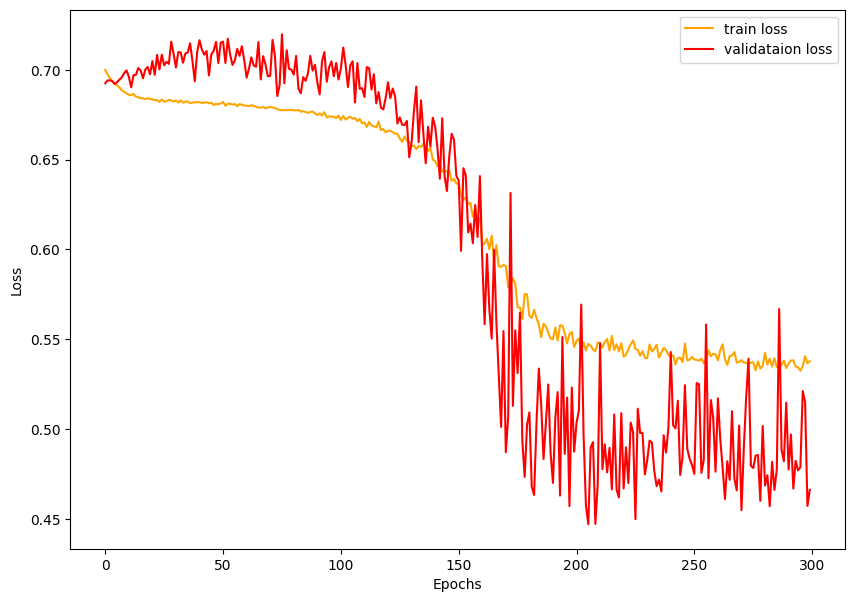

In [29]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='orange', label='train loss')
plt.plot(validation_losses, color='red', label='validataion loss')
# plt.plot(validation_accuracies, color='green', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("{}/figures/Losses by epoch".format(ROOT_DIR))
plt.show()

In [30]:
import gc
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X = X.to(device).float()
        Y=Y.to(device).long()
        print(X.shape)
        print(Y.shape)
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().to('cpu').numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().to('cpu').numpy()

In [31]:
Y_actual, Y_preds = MakePredictions(nr_ahr_classifier, test_loader)
Y_actual[:,-1], Y_preds

torch.Size([32, 291, 45])
torch.Size([32, 1])
torch.Size([32, 291, 45])
torch.Size([32, 1])
torch.Size([32, 291, 45])
torch.Size([32, 1])
torch.Size([32, 291, 45])
torch.Size([32, 1])
torch.Size([32, 291, 45])
torch.Size([32, 1])
torch.Size([7, 291, 45])
torch.Size([7, 1])


(array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]),
 array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [32]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.7844311377245509

Classification Report : 
              precision    recall  f1-score   support

    Inactive       0.73      0.83      0.77        75
      Active       0.84      0.75      0.79        92

    accuracy                           0.78       167
   macro avg       0.79      0.79      0.78       167
weighted avg       0.79      0.78      0.78       167


Confusion Matrix : 
[[62 13]
 [23 69]]


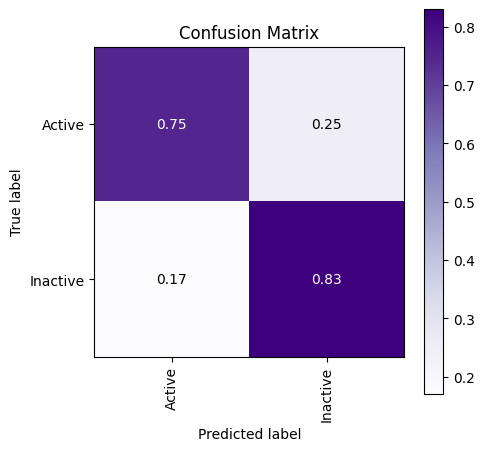

In [33]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual[:,-1]], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [34]:
X_test, Y_test = [], []
for X, Y in test_dataset:
    X_test.append(X)
    Y_test.append(Y)

len(X_test)

167

In [35]:
## Randomly Select test example and make prediction on it.
rng = np.random.RandomState()
idx = rng.randint(1, len(X_test))
preds = nr_ahr_classifier(torch.tensor(X_test[idx:idx+1], dtype=torch.int32).to(device).float())
preds = F.softmax(preds, dim=-1)

print("IDX        = {}".format(idx))
print("Prediction = ", target_classes[preds.argmax()])
print("Actual     = ", target_classes[Y_test[idx][0]])

IDX        = 113
Prediction =  Inactive
Actual     =  Inactive


## Using another tokenizer

In [36]:
# !pip install SmilesPE

In [37]:
import codecs
from SmilesPE.tokenizer import *
from SmilesPE.pretokenizer import atomwise_tokenizer , kmer_tokenizer
spe_vob= codecs.open(f'{ROOT_DIR}/spe/SPE_ChEMBL.txt')
spe = SPE_Tokenizer(spe_vob)

In [38]:
from torchtext.vocab import build_vocab_from_iterator

def tokenize(smiles, tokenizer_type='spe_tokenizer', ngram=2):
    tokens = None
    if tokenizer_type=='spe_tokenizer':
        tokens = spe.tokenize(smiles).split(' ')
    elif tokenizer_type=='kmer_tokenizer':
        tokens = kmer_tokenizer(smiles, ngram)
    elif tokenizer_type=='atomwise_tokenizer':
        tokens = atomwise_tokenizer(smiles)  
    return tokens

def build_vocab_torchtext(datasets, tokenizer_type='spe_tokenizer', ngram=8):
    for dataset in datasets:
        for _, smiles in dataset:
            yield tokenize(smiles, tokenizer_type=tokenizer_type, ngram=ngram)

In [39]:
spe_tkns  = tokenize("c1ccncn1CC(=O)NCC", tokenizer_type='spe_tokenizer')
kmer_tkns = tokenize("c1ccncn1CC(=O)NCC", tokenizer_type='kmer_tokenizer', ngram=2)
atm_tkns  = tokenize("c1ccncn1CC(=O)NCC", tokenizer_type='atomwise_tokenizer')
(len(spe_tkns), ', '.join(spe_tkns)), (len(atm_tkns), ', '.join(atm_tkns))  , (len(kmer_tkns), ', '.join(kmer_tkns))

((4, 'c1cc, ncn1, CC(=O)N, CC'),
 (17, 'c, 1, c, c, n, c, n, 1, C, C, (, =, O, ), N, C, C'),
 (16, 'c1, 1c, cc, cn, nc, cn, n1, 1C, CC, C(, (=, =O, O), )N, NC, CC'))

In [40]:
class SMILESDataset(Dataset):
    def __init__(self, smiles, target):
        self.smiles = smiles
        self.target = target
    def __len__(self):
        return len(self.smiles)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        sample = self.smiles[idx]
        label  = self.target[idx]

        return label, sample

In [41]:
train_dataset_tkns      = SMILESDataset(smiles=train_df[smiles_column].values, target=train_df[target].values)
validation_dataset_tkns = SMILESDataset(smiles=validation_df[smiles_column].values, target=validation_df[target].values)
test_dataset_tkns       = SMILESDataset(smiles=test_df[smiles_column].values, target=test_df[target].values)

### Generate a vocabulary
We will use torchtext's functionalities including vocab, and asssociated functions.
> - https://pytorch.org/text/stable/vocab.html

In [42]:
TOKENIZER_TYPE = 'spe_tokenizer'
N_GRAM = 1

tokens = build_vocab_torchtext([train_dataset_tkns, validation_dataset_tkns, test_dataset_tkns], tokenizer_type=TOKENIZER_TYPE, ngram=N_GRAM)
print(tokens.__class__)
print(dir(tokens))
for t in tokens:
    print(t)
    break


tt_vocab  = build_vocab_from_iterator(tokens
                                      , min_freq=1  # indicates that we'll keep all words whose word frequency is at least min_freq.
                                      , specials=["<UNK>"]
                                     )
tt_vocab.set_default_index(tt_vocab["<UNK>"])

<class 'generator'>
['__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__name__', '__ne__', '__new__', '__next__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'close', 'gi_code', 'gi_frame', 'gi_running', 'gi_yieldfrom', 'send', 'throw']
['C#', 'Cc1cccc(', 'N', 'c2ncn', 'c3cc(', 'OCC', 'OC)c(', 'OCC', 'OC)', 'cc2', '3)c1']


In [43]:
print(train_dataset_tkns[0][1])
x_smiles = train_dataset_tkns[0][1]
tkns = tokenize(x_smiles, tokenizer_type=TOKENIZER_TYPE, ngram=N_GRAM)
print("{} : {} : {}".format(x_smiles, tkns, tt_vocab(tkns)))
print(len(tt_vocab))
# stoi = tt_vocab.vocab.get_stoi()
# stoi_sorted = sorted(stoi.items(), key=lambda x: x[1], reverse=False)
# stoi_sorted

C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1 : ['C#', 'Cc1cccc(', 'N', 'c2ncn', 'c3cc(', 'OCC', 'OC)c(', 'OCC', 'OC)', 'cc2', '3)c1'] : [456, 264, 3, 790, 250, 21, 0, 21, 39, 189, 0]
1667


### Analyzing the token distribution

In [44]:
all_tkns = [tokenize(smi, tokenizer_type=TOKENIZER_TYPE, ngram=N_GRAM) for smi in train_df[smiles_column].values]
all_tkns.sort(key=len)
print(len(all_tkns[-1]))
lengths = pd.DataFrame([len(x) for x in all_tkns], columns=["n_tokens"])
# print(lengths.head(10))
lengths.describe()

52


,n_tokens
count,1330.000000
mean,6.188722
std,4.443748
min,1.000000
25%,4.000000
50%,5.000000
75%,8.000000
max,52.000000


array([[<Axes: title={'center': 'n_tokens'}>]], dtype=object)

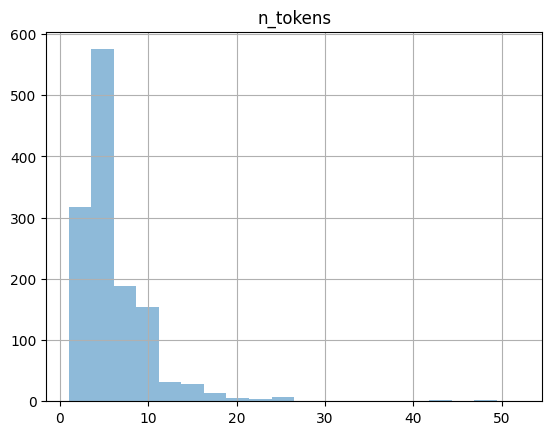

In [45]:
import matplotlib.pyplot as plt

# plt.title("Token Distribution")
lengths.hist(bins=20, alpha=0.5)

The description of the dataframe and the histogram below allow us to find an acceptable threshold to set a maximum of tokens. Given that more than 75% of the compounds appear to have less than 46 SPE-generated tokens, and based on the histogram distribution, we will set the maximum number of tokens used to 75.

In [46]:
print(" {} {} {}".format(train_df.shape, validation_df.shape, test_df.shape))
train_df = utilities.augment_data(train_df, smiles_column, target, n_randomizations=1)
validation_df = utilities.augment_data(validation_df, smiles_column, target, n_randomizations=1)
test_df = utilities.augment_data(test_df, smiles_column, target, n_randomizations=1)
print(" {} {} {}".format(train_df.shape, validation_df.shape, test_df.shape))

 (1330, 6) (166, 6) (167, 6)
 (2622, 2) (330, 2) (333, 2)


In [180]:
# max_tokens=len(tt_vocab)
max_tokens=20
batch_size=16
# copied from https://coderzcolumn.com/tutorials/artificial-intelligence/word-embeddings-for-pytorch-text-classification-networks
def vectorize_batch(batch):
    Y, X = list(zip(*batch))
#     print(Y)
#     print(X)
    X = [tt_vocab(tokenize(sample)) for sample in X]
    X = [tokens+([0]* (max_tokens-len(tokens))) if len(tokens)<max_tokens else tokens[:max_tokens] for tokens in X] ## Bringing all samples to max_tokens length.
    return torch.tensor(X), torch.tensor(Y)


train_loader_tkns       = DataLoader(train_dataset_tkns, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
validation_loader_tkns  = DataLoader(validation_dataset_tkns, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader_tkns        = DataLoader(test_dataset_tkns, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)

In [181]:
temp_x = None
temp_y = None
for X_, Y_ in train_loader_tkns:
    print("X = {} - Y= {}".format(len(X_),len(Y_)))
    print(X_)
    print(Y_)
    temp_x = X_
    temp_y = Y_
    break

X = 16 - Y= 16
tensor([[ 236,  137,  249,  204,  118,  606,   34,   57,  128,   68,  245, 1580,  816,    0,    0,    0,    0,    0,
            0,    0],
        [ 211, 1280,    4,  792, 1653,  123,  113,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   8,  252,   24,  129,    8,   55,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   6,   22,   19,  389,  378,  298,   12,    9,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [ 350,    3,   51,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [ 185,  972,   98,    1,  147,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   1,  620,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  4

Below, we define a classifier class called that implements **stacked LSTMs** where the first LSTM has one **layer**, while the second has two. While the first layer is **bidirectional**, the second could be birectional if set by the user.


In [182]:
class LSTMNet(nn.Module):
    def __init__(self, num_tokens, embedding_dim, lstm_size, hidden_size, dropout_rate, out_size, num_layers=1, bidirectional=False):
        super(LSTMNet, self).__init__()
    
        multiplier=1
        if bidirectional:
            multiplier=2
        self.embedding = nn.Embedding(num_embeddings=num_tokens, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
#         self.lstm2 = nn.LSTM(input_size=lstm_size, hidden_size=lstm_size + 10, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc1  = nn.Linear(multiplier*lstm_size, hidden_size) # Output layer
#         self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out  = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)
        
        for layer in self.children():
            print("Layer : {}".format(layer))
            print("Parameters : ")
            # https://blog.paperspace.com/pytorch-101-advanced/
            for param in layer.named_parameters():
                print("{} : {}".format(param[0], param[1].shape))
            print()

    def forward(self, x):# Forward pass: stacking each layer together
        embeddings = self.embedding(x.long())
#         print("embeddings: {}".format(embeddings.shape))
        out, (h_n, c_n) = self.lstm(embeddings) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        
        out = self.dropout(out) # Dropout
        out = self.fc1(out) # Pass into the hidden layer
#         out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out[:,-1,:]



In [185]:
num_tokens    = len(tt_vocab) 
embedding_dim = 128
epochs        = 450
target_classes = ['Inactive', 'Active']
lstm_size     = 256  # The size of the LSTM layer
hidden_size   = 256  # The size of the hidden non-linear layer
dropout_rate  = 0.3 # The dropout rate
output_size   = 2        # This is just a single task, so this will be one
learning_rate = 0.01  # The initial learning rate for the optimizer
lr_patience   = 10
loss_func = nn.CrossEntropyLoss()

nr_ahr_classifier_tkns = LSTMNet(num_tokens, embedding_dim, lstm_size, hidden_size, dropout_rate, output_size, num_layers=2, bidirectional=True)
nr_ahr_classifier_tkns.to(device)

optimizer = torch.optim.Adadelta(nr_ahr_classifier_tkns.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5
                                 , patience=lr_patience # Number of epochs with no improvement after which learning rate will be reduced
                                 , verbose=True
                                 , threshold=0.001
                                 , threshold_mode='rel', cooldown=0, min_lr=learning_rate, eps=1e-06)

lr_step_scheduler = StepLR(optimizer, step_size=100, gamma=0.05)


temp_x = [tt_vocab(tokenize(sample)) for sample in [train_dataset_tkns[0][1]]]
temp_x = [tokens+([0] * (max_tokens-len(tokens))) if len(tokens)<max_tokens else tokens[:max_tokens] for tokens in temp_x] ## Bringing all samples to max_tokens length.
temp_y =  train_dataset_tkns[0][0]
print(temp_x)
print(temp_y)
t = nr_ahr_classifier_tkns.forward(torch.tensor([temp_x][0]).to(device))
t, F.softmax(t, dim=-1), F.softmax(t, dim=-1).argmax(dim=-1).item(), temp_y

Layer : Embedding(1667, 128)
Parameters : 
weight : torch.Size([1667, 128])

Layer : LSTM(128, 256, num_layers=2, batch_first=True, bidirectional=True)
Parameters : 
weight_ih_l0 : torch.Size([1024, 128])
weight_hh_l0 : torch.Size([1024, 256])
bias_ih_l0 : torch.Size([1024])
bias_hh_l0 : torch.Size([1024])
weight_ih_l0_reverse : torch.Size([1024, 128])
weight_hh_l0_reverse : torch.Size([1024, 256])
bias_ih_l0_reverse : torch.Size([1024])
bias_hh_l0_reverse : torch.Size([1024])
weight_ih_l1 : torch.Size([1024, 512])
weight_hh_l1 : torch.Size([1024, 256])
bias_ih_l1 : torch.Size([1024])
bias_hh_l1 : torch.Size([1024])
weight_ih_l1_reverse : torch.Size([1024, 512])
weight_hh_l1_reverse : torch.Size([1024, 256])
bias_ih_l1_reverse : torch.Size([1024])
bias_hh_l1_reverse : torch.Size([1024])

Layer : Linear(in_features=512, out_features=256, bias=True)
Parameters : 
weight : torch.Size([256, 512])
bias : torch.Size([256])

Layer : Linear(in_features=256, out_features=2, bias=True)
Parameter

(tensor([[0.0394, 0.0115]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[0.5070, 0.4930]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 0,
 1)

In [186]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, lr_scheduler_list=None, epochs=10):
    train_losses = []
    validation_losses = []
    validation_accuracies = []
    for i in range(1, epochs+1):       
        losses = []
        for X, Y in train_loader:
            X = X.to(device).float()
            Y = Y.to(device).long()
            Y_preds = model(X) ## Make Predictions
            loss = loss_func(Y_preds, Y.view(-1)) ## Calculate Loss
            losses.append(loss.item())
            optimizer.zero_grad() ## Clear previously calculated gradients
            loss.backward() ## Calculates Gradients
            optimizer.step() ## Update network weights.
            
        train_loss = torch.tensor(losses).mean().item()
        train_losses.append(train_loss)
#         print("Train Loss : {:.3f}".format(train_loss))
        validation_loss, validation_acc = CalcValLossAndAccuracy(model, loss_func, val_loader)
        validation_losses.append(validation_loss.item())
        validation_accuracies.append(validation_acc)
        
        if lr_scheduler_list is not None:
            for lr_scheduler in lr_scheduler_list:
                    lr_scheduler.step(validation_loss)
        
        
        if (i+1)%10 == 0:
            print("Epoch {}: Training Loss {:.3f} Validation Loss {:.3f} Validation Accuracy {:.3f}".format(i+1, train_loss, validation_loss, validation_acc))
        
    return train_losses, validation_losses, validation_accuracies


train_losses_tkns, validation_losses_tkns, validation_accuracies_tkns = TrainModel(nr_ahr_classifier_tkns, loss_func
                                                                                   , optimizer, train_loader_tkns, validation_loader_tkns
                                                                                   , lr_scheduler_list=[lr_scheduler], epochs=epochs)

Epoch 10: Training Loss 0.684 Validation Loss 0.709 Validation Accuracy 0.476
Epoch 20: Training Loss 0.686 Validation Loss 0.712 Validation Accuracy 0.476
Epoch 30: Training Loss 0.685 Validation Loss 0.709 Validation Accuracy 0.476
Epoch 40: Training Loss 0.685 Validation Loss 0.706 Validation Accuracy 0.476
Epoch 50: Training Loss 0.686 Validation Loss 0.710 Validation Accuracy 0.476
Epoch 60: Training Loss 0.685 Validation Loss 0.708 Validation Accuracy 0.476
Epoch 70: Training Loss 0.683 Validation Loss 0.706 Validation Accuracy 0.476
Epoch 80: Training Loss 0.686 Validation Loss 0.710 Validation Accuracy 0.476
Epoch 90: Training Loss 0.685 Validation Loss 0.708 Validation Accuracy 0.476
Epoch 100: Training Loss 0.685 Validation Loss 0.709 Validation Accuracy 0.476
Epoch 110: Training Loss 0.683 Validation Loss 0.709 Validation Accuracy 0.476
Epoch 120: Training Loss 0.682 Validation Loss 0.708 Validation Accuracy 0.476
Epoch 130: Training Loss 0.685 Validation Loss 0.707 Validati

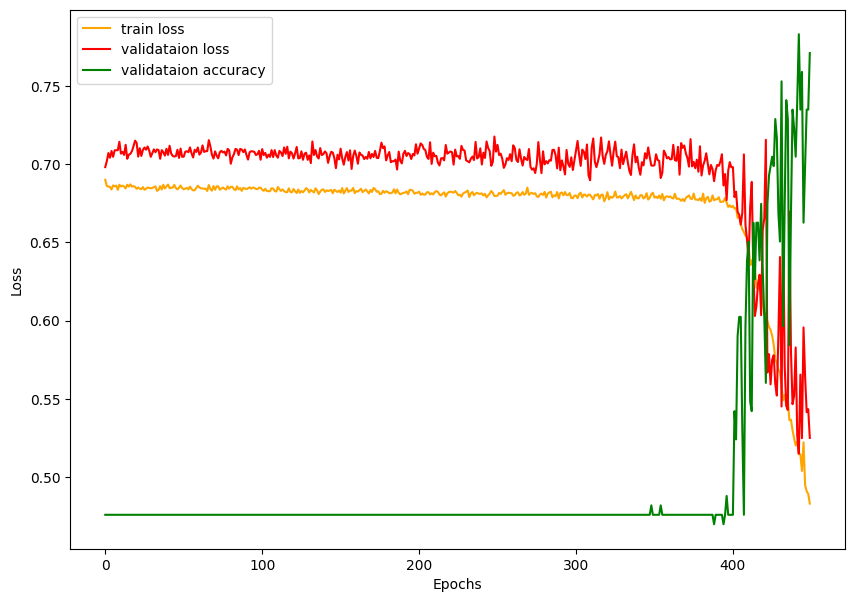

In [188]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_losses_tkns, color='orange', label='train loss')
plt.plot(validation_losses_tkns, color='red', label='validataion loss')
plt.plot(validation_accuracies_tkns, color='green', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("{}/figures/Losses by epoch".format(ROOT_DIR))
plt.show()

In [189]:
X_test_tkns, Y_test_tkns = [], []
for X, Y in test_loader_tkns:
#     print(X.shape)
#     print(Y.shape)
    X_test_tkns.append(X)
    Y_test_tkns.append(Y)

print(len(X_test_tkns))
Y_actual_tkns, Y_preds_tkns = MakePredictions(nr_ahr_classifier_tkns, test_loader_tkns)

11
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([16, 20])
torch.Size([16])
torch.Size([7, 20])
torch.Size([7])


In [190]:
Y_actual_tkns, Y_preds_tkns

(array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]),
 array([1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0

In [191]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual_tkns, Y_preds_tkns)))
print("\nClassification Report : ")
print(classification_report(Y_actual_tkns, Y_preds_tkns, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual_tkns, Y_preds_tkns))

Test Accuracy : 0.718562874251497

Classification Report : 
              precision    recall  f1-score   support

    Inactive       0.67      0.73      0.70        75
      Active       0.76      0.71      0.73        92

    accuracy                           0.72       167
   macro avg       0.72      0.72      0.72       167
weighted avg       0.72      0.72      0.72       167


Confusion Matrix : 
[[55 20]
 [27 65]]


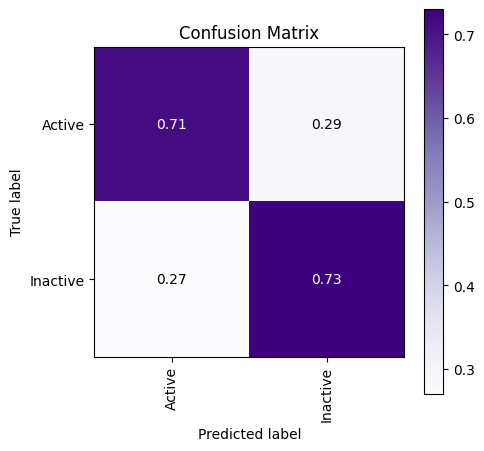

In [192]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual_tkns], [target_classes[i] for i in Y_preds_tkns],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [193]:
def make_predictions_from_smiles(X_batch_smiles): ## Prediction Function
    X = [tt_vocab(tokenize(smiles)) for smiles in X_batch_smiles]
    X = [tokens+([0]* (max_tokens-len(tokens))) if len(tokens)<max_tokens else tokens[:max_tokens] for tokens in X] ## Bringing all samples to max_words length.
    logits = nr_ahr_classifier_tkns(torch.tensor(X, dtype=torch.int32).to(device))
    preds = F.softmax(logits, dim=-1)
    return preds.detach().to('cpu').numpy() ## Make sure to detach the tensor. Otherwise, you'll get TypeError: can't convert cuda:0 device type tensor to numpy

In [194]:
X_batch_smiles, Y_batch_smiles = [], []
for Y, X in test_dataset_tkns:
    X_batch_smiles.append(X)
    Y_batch_smiles.append(Y)

len(X_batch_smiles)

167

### Explaining prediction results with Local Interpretable Model-agnostic Explanation (LIME)
In this section, we explain the predictions made by our model using LIME algorithm which is a commonly used library to explain predictions of black-box neural network models. LIME helps visualizing the parts of the SMILES strings that that contributed to predicting the predicted outcome.

If you are new to LIME and have no background on it then we recommend that you go through the below link to understand it.
> - [How to Use LIME to Interpret Predictions of ML Models?](https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions)

In [195]:
rng = np.random.RandomState()
idx = rng.randint(1, len(X_batch_smiles))
X = [tt_vocab(tokenize(smiles)) for smiles in X_batch_smiles[idx:idx+1]]
X = [tokens+([0]* (max_tokens-len(tokens))) if len(tokens)<max_tokens else tokens[:max_tokens] for tokens in X] ## Bringing all samples to max_words length.

preds = nr_ahr_classifier_tkns(torch.tensor(X, dtype=torch.int32).to(device))
preds = F.softmax(preds, dim=-1)

print(preds)
print(preds.argmax())
print("Prediction (idx {}) : {}".format(idx, target_classes[preds.argmax()]))
print("Actual     (idx {}) : {}".format(idx, target_classes[Y_batch_smiles[idx]]))

tensor([[0.6080, 0.3920]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor(0, device='cuda:0')
Prediction (idx 123) : Inactive
Actual     (idx 123) : Inactive


In [159]:
lime_explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True)
lime_explanation = lime_explainer.explain_instance(X_batch_smiles[idx], classifier_fn=make_predictions_from_smiles,
                                         labels=Y_batch_smiles[idx:idx+1])
lime_explanation.show_in_notebook()

Intercept 0.2746319176129072
Prediction_local [0.82334407]
Right: 0.9846466



### Explaining prediction results with SHAP
In this section, we have tried to explain predictions made by our network by generating **SHAP** values using shap python library. In order to use shap library, we need to import it and initialize it by calling **initjs()** function on it which we did at the beginning of the tutorial.

In order to explain a prediction using SHAP values, we need to create **Explainer** first. Then, we need to give text examples that we want to explain to the explainer instance to create **Explanation** object (SHAP values). At last, we can call **text_plot()** method by giving SHAP values to it to visualize explanations created for text examples.

Below, we have first created an explainer object. The explainer object requires us to provide a function that takes as an input batch of text examples and returns probabilities for each target class for the whole batch. We have created a simple function that takes as an input batch of text samples. It then tokenizes them and creates indexes for tokens using vocabulary. It then assures that each text sample has a length of ***max_tokens*** as required by our network. Then, it gives vectorized batch data to the network to make predictions. As our network returns logits, we have converted them to probabilities using **softmax** activation function. We have also given target class names when creating explainer instances.

If you do not have a background on SHAP library then we suggest the below-mentioned tutorials that can be very helpful to learn it.
> - [SHAP - Explain Machine Learning Model Predictions using Game-Theoretic Approach](https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach)
> - [SHAP Values for Text Classification Tasks (Keras NLP)](https://coderzcolumn.com/tutorials/artificial-intelligence/shap-values-for-text-classification-tasks)

In [196]:
import re

##https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
def custom_tokenizer(smiles, return_offsets_mapping=True):
    """
    This is a tokenizer that will be passed to the shap explainer
    """
    s = ' '.join(tokenize(smiles, tokenizer_type=TOKENIZER_TYPE, ngram=N_GRAM))
#     print("\ns={}".format(s))
    pattern = r'\W'
    matches = re.finditer(pattern, s)

    pos = 0
    offset_ranges = []
    input_ids = []

    for match in matches:
    #     print(match)
        start, end = match.span(0)
        offset_ranges.append((pos, start))
        input_ids.append(s[pos:start])
        pos = end    
#         print("start {} end {} offset_ranges {} input_ids {}".format(start, end, offset_ranges, input_ids))
    if pos != len(s):
        offset_ranges.append((pos, len(s)))
        input_ids.append(s[pos:])
    # print("input_ids {}".format(input_ids))
    out = {}
    out["input_ids"] = input_ids

    if return_offsets_mapping:
        out["offset_mapping"] = offset_ranges
#     print(out)
    return out

# custom_tokenizer("CCCOCCCc1cnccn1", return_offsets_mapping=True)

In [200]:
masker    = shap.maskers.Text(custom_tokenizer)
shap_explainer = shap.Explainer(make_predictions_from_smiles, masker=masker, output_names=target_classes)
shap_explainer

In [201]:
print("Prediction (idx {}) : {}".format(idx, target_classes[preds.argmax()]))
print("Actual     (idx {}) : {}".format(idx, target_classes[Y_batch_smiles[idx]]))
shap_values = shap_explainer(X_batch_smiles[idx:idx+1])
shap.text_plot(shap_values)

Prediction (idx 123) : Inactive
Actual     (idx 123) : Inactive
